In [192]:
import rioxarray as rxr
import rasterio
from rasterio.windows import from_bounds
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
import tempfile
import os
from shapely.geometry import Point
from shapely.geometry import mapping

import seaborn as sns


Note that these paths may change as we tear down and recalculate burn metrics through development:

In [193]:
RBR_URL = "https://burn-severity-backend.s3.us-east-2.amazonaws.com/public/dse/York/rbr.tif"
DNBR_URL = "https://burn-severity-backend.s3.us-east-2.amazonaws.com/public/dse/York/dnbr.tif"
BOUNDARY_URL = "https://burn-severity-backend.s3.us-east-2.amazonaws.com/public/dse/York/boundary.geojson"


In [194]:
with tempfile.TemporaryDirectory() as temp_dir:
    # RBR
    RBR_PATH = os.path.join(temp_dir, "rbr.tif")
    r = requests.get(RBR_URL, allow_redirects=True)
    open(RBR_PATH, "wb").write(r.content)
    rbr = rxr.open_rasterio(RBR_PATH, masked=True).squeeze()

    # dNBR
    DNBR_PATH = os.path.join(temp_dir, "dnbr.tif")
    r = requests.get(DNBR_URL, allow_redirects=True)
    open(DNBR_PATH, "wb").write(r.content)
    dnbr = rxr.open_rasterio(DNBR_PATH, masked=True).squeeze()

    # Geojson of the fire perimeter
    BOUNDARY_PATH = os.path.join(temp_dir, "boundary.geojson")
    r = requests.get(BOUNDARY_URL, allow_redirects=True)
    open(BOUNDARY_PATH, "wb").write(r.content)
    boundary = gpd.read_file(BOUNDARY_PATH)


In [195]:
rbr

<xarray.DataArray (y: 1832, x: 1271)>
[2328472 values with dtype=float64]
Coordinates:
    band         int64 1
  * x            (x) float64 -115.3 -115.3 -115.3 ... -115.1 -115.1 -115.1
  * y            (y) float64 35.48 35.48 35.48 35.48 ... 35.13 35.13 35.13 35.13
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      stackstac-a396c2701a14f53fb07f569bb80fc46e

In [196]:
dnbr

<xarray.DataArray (y: 1832, x: 1271)>
[2328472 values with dtype=float64]
Coordinates:
    band         int64 1
  * x            (x) float64 -115.3 -115.3 -115.3 ... -115.1 -115.1 -115.1
  * y            (y) float64 35.48 35.48 35.48 35.48 ... 35.13 35.13 35.13 35.13
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      stackstac-a396c2701a14f53fb07f569bb80fc46e

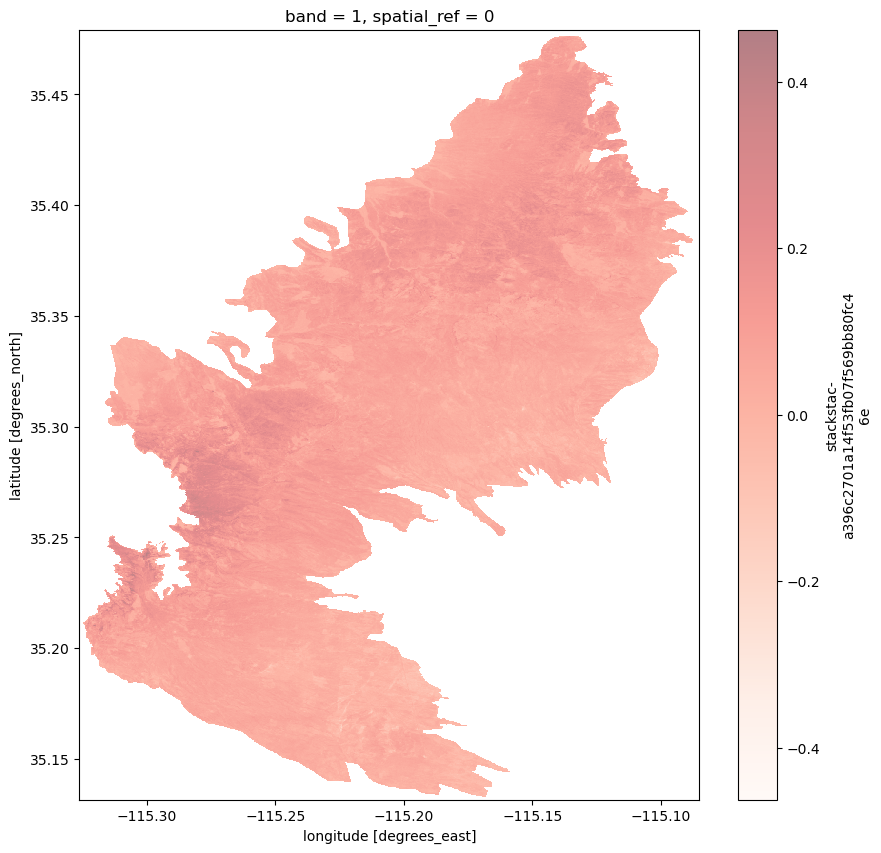

In [197]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the rbr dataArray
rbr.rio.reproject("EPSG:4326").plot.imshow(ax=ax, cmap='Reds', alpha=0.5)

plt.show()


The following `york_burn_field_observations_interpreted` are equivalent to what we've recieved from Nick Graver (`202308_YorkSeverityObservationPoints.csv`), wherein I simply split up two observations where comments indicated "high severity to north, low to south" and the like. 

In [198]:
# severity_points_df = pd.read_csv('202308_YorkSeverityObservationPoints.csv')
severity_points_df = pd.read_csv('york_burn_field_observations_interpreted.csv')

In [199]:
severity_points_df['geometry'] = severity_points_df.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)
severity_points_gdf = gpd.GeoDataFrame(severity_points_df, geometry='geometry')
severity_points_gdf.crs = 'EPSG:4326'
severity_points_gdf.rename(columns={'name': 'FieldDescription'}, inplace=True)
severity_points_gdf.set_index('FID', inplace=True)
severity_points_gdf

,FieldDescription,TimeStamp,Longitude,Latitude,SeverityFactor,geometry
FID,,,,,,
1,High Severity,8/1/2023 0:00,-115.172180,35.296247,3,POINT (-115.17218 35.29625)
2,High severity,8/2/2023 0:00,-115.226196,35.302168,3,POINT (-115.22620 35.30217)
3,High severity/mortality YUJA woodlands,7/31/2023 0:00,-115.257442,35.316332,3,POINT (-115.25744 35.31633)
4,Higher burn severity,7/31/2023 0:00,-115.215690,35.253257,3,POINT (-115.21569 35.25326)
5,Higher severity,7/31/2023 0:00,-115.227215,35.289627,3,POINT (-115.22722 35.28963)
6,Moderate severity,7/31/2023 0:00,-115.192904,35.282274,2,POINT (-115.19290 35.28227)
7,Moderate severity,8/1/2023 0:00,-115.094502,35.369178,2,POINT (-115.09450 35.36918)
8,Moderate severity,8/2/2023 0:00,-115.235698,35.271425,2,POINT (-115.23570 35.27143)
9,Moderate severity YucSch woodlands,7/31/2023 0:00,-115.296759,35.333723,2,POINT (-115.29676 35.33372)


In [200]:
with open('burn_field_observations.geojson', 'w') as f:
    f.write(severity_points_gdf.to_json())

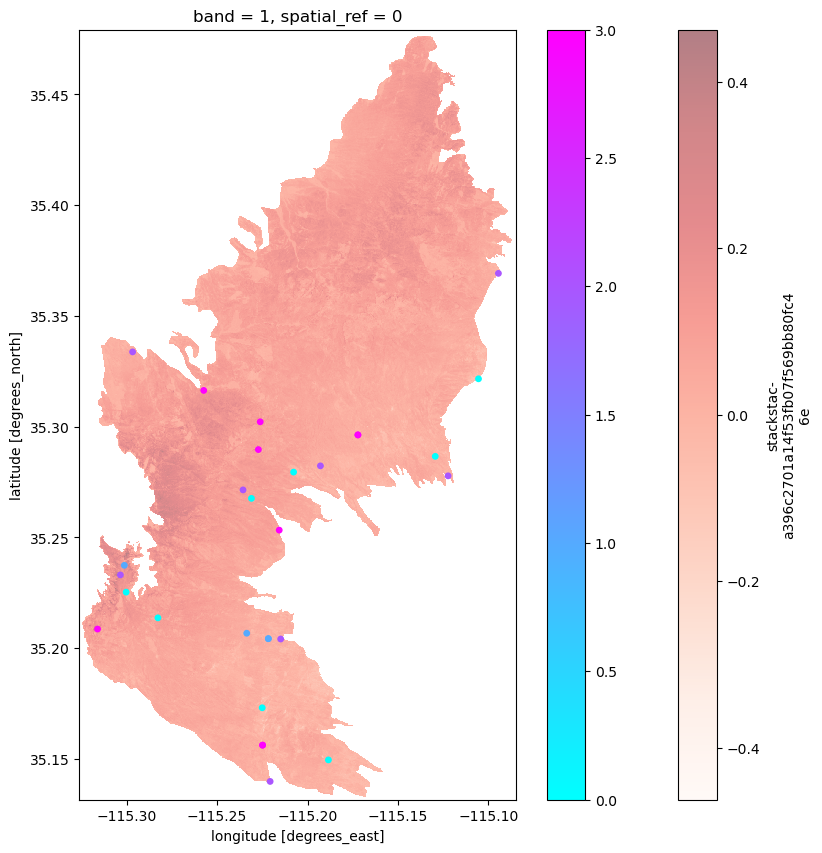

In [201]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the rbr dataArray
rbr.rio.reproject("EPSG:4326").plot.imshow(ax=ax, cmap='Reds', alpha=0.5)

# Plot the gdf points with color based on SeverityFactor
severity_points_gdf.plot(ax=ax, column='SeverityFactor', cmap='cool', markersize=15)

# Add legend for SeverityFactor
legend = ax.get_legend()
if legend is None:
    severity_points_gdf.plot(ax=ax, column='SeverityFactor', cmap='cool', markersize=0, legend=True)

plt.show()


In [202]:
# Empty dataframe to store results
df_results = []

# Iterate over each point
for idx, row in severity_points_gdf.iterrows():
    # Draw a circle around the point
    circle = row.geometry.buffer(0.001)
    
    # Get pixels within the circle for each DataArray
    pixels_rbr = rbr.rio.clip([circle])
    pixels_dnbr = dnbr.rio.clip([circle])
    
    # Aggregate pixels and store the result
    result = {
        'FID': idx,
        'mean_rbr': pixels_rbr.mean().values.item(),
        'median_rbr': pixels_rbr.median().values.item(),
        'std_rbr': pixels_rbr.std().values.item(),
        'mean_dnbr': pixels_dnbr.mean().values.item(),
        'median_dnbr': pixels_dnbr.median().values.item(),
        'std_dnbr': pixels_dnbr.std().values.item()
    }

    df_results.append(result)

# Convert to geopandas dataframe
gdf_aggregated_metrics = gpd.GeoDataFrame(df_results).set_index('FID')

In [203]:
gdf_aggr = severity_points_gdf.join(gdf_aggregated_metrics)

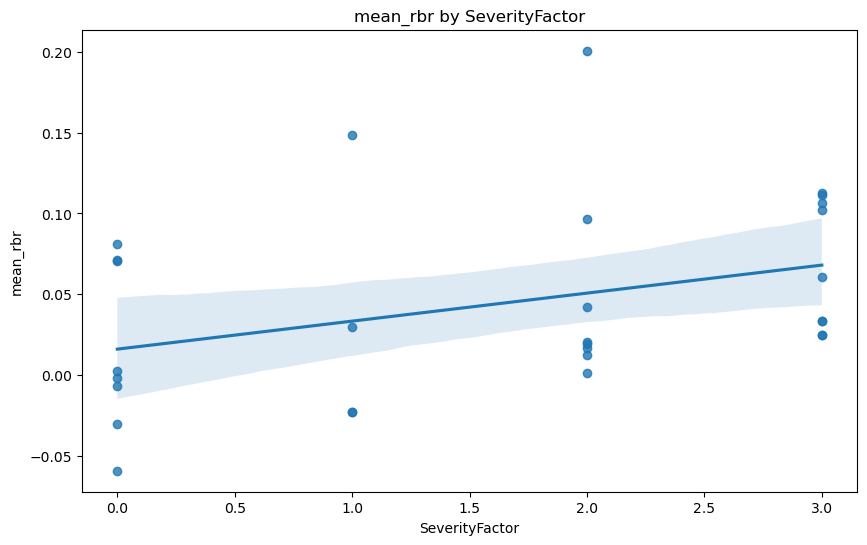

In [204]:
plt.figure(figsize=(10, 6))
sns.regplot(x='SeverityFactor', y='mean_rbr', data=gdf_aggr)
plt.title('mean_rbr by SeverityFactor')
plt.show()

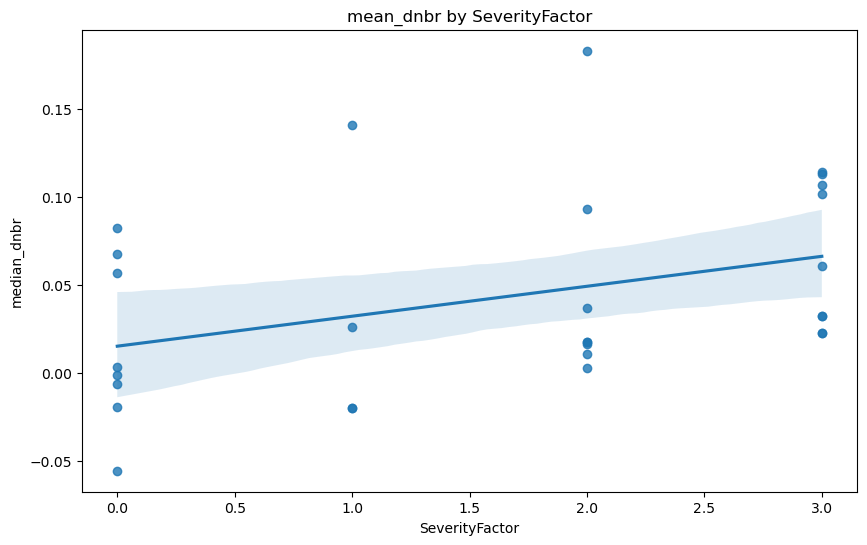

In [205]:
plt.figure(figsize=(10, 6))
sns.regplot(x='SeverityFactor', y='median_dnbr', data=gdf_aggr)
plt.title('mean_dnbr by SeverityFactor')
plt.show()

Not particularly useful, but it's a start. In order to get _some_ idea of prefire conditions, lets look at 2022 rangeland analysis platform outputs for this area, to see if we notice any trends.

According to Rangeland Analysis Platform README (http://rangeland.ntsg.umt.edu/data/rap/rap-vegetation-npp/v3/README)
- Band 1 - annual forb and grass
- Band 2 - perennial forb and grass
- Band 3 - shrub
- Band 4 - tree
- No Data value = 65535

In [206]:
def geotiff_subset_cog(geotiff_url, boundary_gdf, buffer_distance):
    # Load boundary geometry (in GeoJSON format)
    minx, miny, maxx, maxy = boundary_gdf.total_bounds

    # Create a buffer around the boundary
    boundary_gdf_buffer = boundary_gdf.buffer(buffer_distance)

    # Create a window from the buffered boundary
    with rasterio.open(geotiff_url) as src:
        window = rasterio.windows.from_bounds(minx, miny, maxx, maxy, src.transform)

    # Open the GeoTIFF file as a rioxarray with the window and out_shape parameters
    xds = rxr.open_rasterio(geotiff_url, masked=True).rio.isel_window(window)

    # Rename for RAP
    xds = xds.assign_coords(
        band=("band",
              ["annual_forb_and_grass", "perennial_forb_and_grass", "shrub", "tree"]
        )
    )

    xds = xds.rio.clip(boundary_gdf_buffer.geometry.values, 'EPSG:4326')

    # add np.nan where 65535
    xds = xds.where(xds != 65535, np.nan)

    return xds

buffer_distance = 0.01

rap_subset = geotiff_subset_cog(
    geotiff_url='http://rangeland.ntsg.umt.edu/data/rap/rap-vegetation-npp/v3/vegetation-npp-v3-2022.tif', 
    boundary_gdf=boundary,
    buffer_distance=buffer_distance
)


/tmp/ipykernel_51446/2316562881.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  boundary_gdf_buffer = boundary_gdf.buffer(buffer_distance)


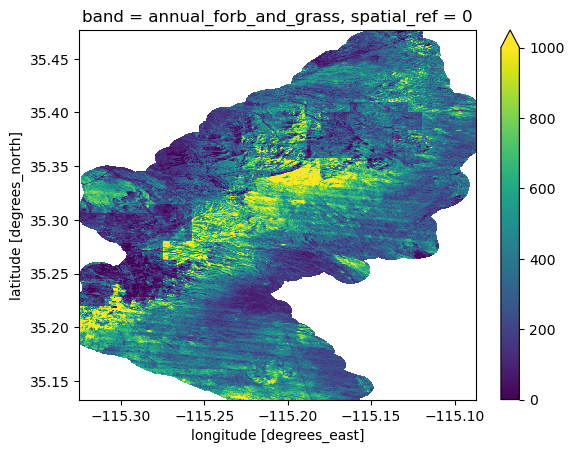

In [207]:
# Convert the 'band' dimension into a coordinate
rap_subset.sel({'band': 'annual_forb_and_grass'}).plot(cmap='viridis', robust=True, vmin=0, vmax=1000)

In [208]:
rap_subset


<xarray.DataArray (band: 4, y: 1277, x: 882)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 -115.3 -115.3 -115.3 ... -115.1 -115.1 -115.1
  * y            (y) float64 35.48 35.48 35.48 35.48 ... 35.13 35.13 35.13 35.13
  * band         (band) <U24 'annual_forb_and_grass' ... 'tree'
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [209]:
# Empty dataframe to store results
df_results = []

# Iterate over each point
for idx, row in severity_points_gdf.iterrows():
    # Draw a circle around the point
    circle = row.geometry.buffer(0.001)
    
    # Get pixels within the circle for each DataArray
    pixels_annual = rap_subset.sel({'band': 'annual_forb_and_grass'}).rio.clip([circle])
    pixels_perennial = rap_subset.sel({'band': 'perennial_forb_and_grass'}).rio.clip([circle])
    pixels_shrub = rap_subset.sel({'band': 'shrub'}).rio.clip([circle])
    pixels_tree = rap_subset.sel({'band': 'tree'}).rio.clip([circle])

    # Aggregate pixels and store the result
    result = {
        'FID': idx,
        'mean_annual': pixels_annual.mean().values.item(),
        'median_annual': pixels_annual.median().values.item(),
        'std_annual': pixels_annual.std().values.item(),
        'mean_perennial': pixels_perennial.mean().values.item(),
        'median_perennial': pixels_perennial.median().values.item(),
        'std_perennial': pixels_perennial.std().values.item(),
        'mean_shrub': pixels_shrub.mean().values.item(),
        'median_shrub': pixels_shrub.median().values.item(),
        'std_shrub': pixels_shrub.std().values.item(),
        'mean_tree': pixels_tree.mean().values.item(),
        'median_tree': pixels_tree.median().values.item(),
        'std_tree': pixels_tree.std().values.item()
    }

    df_results.append(result)

# Convert to geopandas dataframe
gdf_aggregated_rap = gpd.GeoDataFrame(df_results).set_index('FID')

In [210]:
gdf_aggr_rap_metrics = gdf_aggr.join(gdf_aggregated_rap)

In [211]:
gdf_aggr_rap_metrics

,FieldDescription,TimeStamp,Longitude,Latitude,SeverityFactor,geometry,mean_rbr,median_rbr,std_rbr,mean_dnbr,...,std_annual,mean_perennial,median_perennial,std_perennial,mean_shrub,median_shrub,std_shrub,mean_tree,median_tree,std_tree
FID,,,,,,,,,,,,,,,,,,,,,
1,High Severity,8/1/2023 0:00,-115.172180,35.296247,3,POINT (-115.17218 35.29625),0.024699,0.024442,0.018938,0.023293,...,103.304161,282.522736,257.5,139.753098,162.977280,156.5,33.189190,0.000000,0.0,0.000000
2,High severity,8/2/2023 0:00,-115.226196,35.302168,3,POINT (-115.22620 35.30217),0.102397,0.106216,0.020557,0.104615,...,112.976540,346.568176,331.5,92.655373,97.295456,94.5,22.640049,0.000000,0.0,0.000000
3,High severity/mortality YUJA woodlands,7/31/2023 0:00,-115.257442,35.316332,3,POINT (-115.25744 35.31633),0.106372,0.119165,0.042621,0.100870,...,88.111481,267.386353,255.0,77.804596,116.090912,107.5,27.947855,0.409091,0.0,1.642036
4,Higher burn severity,7/31/2023 0:00,-115.215690,35.253257,3,POINT (-115.21569 35.25326),0.060968,0.062762,0.011493,0.060097,...,83.382179,89.568184,87.0,40.422428,206.613632,218.0,33.955330,0.000000,0.0,0.000000
5,Higher severity,7/31/2023 0:00,-115.227215,35.289627,3,POINT (-115.22722 35.28963),0.111190,0.113145,0.026096,0.110387,...,206.073257,307.023804,299.0,128.363785,136.857147,133.0,49.128872,3.238095,3.0,3.235293
6,Moderate severity,7/31/2023 0:00,-115.192904,35.282274,2,POINT (-115.19290 35.28227),0.020500,0.017782,0.016273,0.019169,...,39.825161,251.738098,248.0,85.621834,149.785721,150.0,21.808186,0.000000,0.0,0.000000
7,Moderate severity,8/1/2023 0:00,-115.094502,35.369178,2,POINT (-115.09450 35.36918),0.001457,0.002989,0.013128,0.001496,...,34.542362,140.023254,154.0,47.302826,157.116272,164.0,22.492592,0.000000,0.0,0.000000
8,Moderate severity,8/2/2023 0:00,-115.235698,35.271425,2,POINT (-115.23570 35.27143),0.096596,0.093328,0.020483,0.098350,...,102.576653,192.659088,183.0,44.351868,291.818176,290.5,37.573730,0.000000,0.0,0.000000
9,Moderate severity YucSch woodlands,7/31/2023 0:00,-115.296759,35.333723,2,POINT (-115.29676 35.33372),0.042095,0.039985,0.015772,0.039242,...,48.053261,205.804352,200.0,36.980381,57.304348,57.5,11.460461,0.000000,0.0,0.000000


<Figure size 1000x600 with 0 Axes>

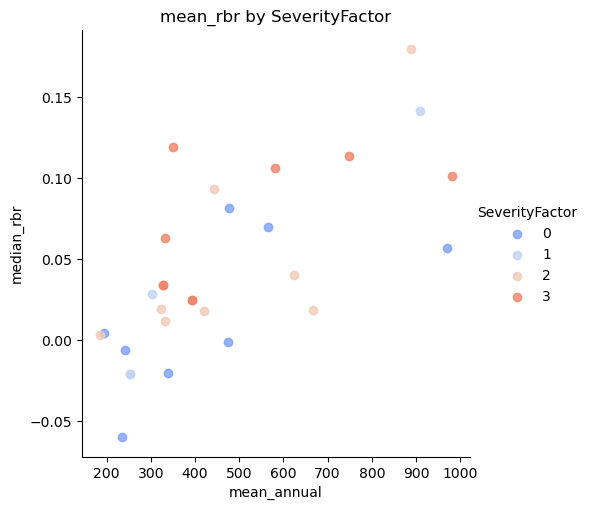

In [212]:
plt.figure(figsize=(10, 6))
sns.lmplot(x='mean_annual', y='median_rbr', hue='SeverityFactor', fit_reg=False, data=gdf_aggr_rap_metrics, palette='coolwarm')
plt.title('mean_rbr by SeverityFactor')
plt.show()

<Figure size 1000x600 with 0 Axes>

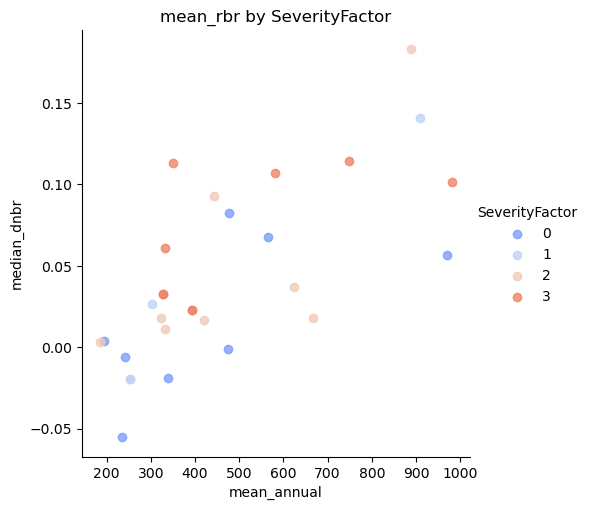

In [214]:
plt.figure(figsize=(10, 6))
sns.lmplot(x='mean_annual', y='median_dnbr', hue='SeverityFactor', fit_reg=False, data=gdf_aggr_rap_metrics, palette='coolwarm')
plt.title('mean_rbr by SeverityFactor')
plt.show()

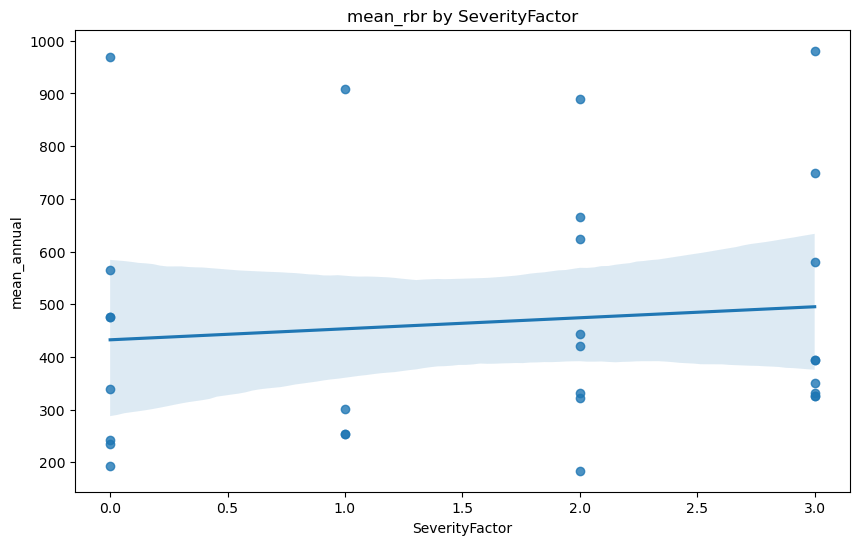

In [213]:
plt.figure(figsize=(10, 6))
sns.regplot(x='SeverityFactor', y='mean_annual', data=gdf_aggr_rap_metrics)
plt.title('mean_rbr by SeverityFactor')
plt.show()